# Визуальный анализ профессий

## Цель исследования

На этапе [исследовательского анализа данных](eda.ipynb) мы видели, что ответ на открытый вопрос "Кем ты рабоатешь" представлен 20 тыс. значениями с неравномерным распределением. Есть 10% часто встречающихся вариантов ответов, есть 3/4 вариантов, встречающихся по 1 разу. 

Наша задача для каждого ответа найти самое близкое значение в классификаторе профессий, содержащим ограниченное множество значений. 

В общем случае нам надо найти функцию преобразования ответа $\alpha$ в значение профессии $\kappa$ из справочника профессий $k$

$\kappa = f(\alpha, k)$

так, чтобы расстояние между этими значениями стремилось к нулю:

$D(\alpha, \kappa) \rightarrow 0$

При этом функция $f$ должна обладать таким свойством, что схожие по значению документы (ответы и/или профессии) в вектроном пространстве находятся рядом, а разные по значению -- далеко друг от друга.

Рассмотрим подход к решению, основанный на преобразовании текстов в численные многомерные вектора (эмбеддинги), позволяющий нам оперировать понятием расстояния между словами через математические функции.

Убедимся, что функция преобразования текстов в эмбединги позволяет нам получить близкие по смыслу документы рядом, а разные по смыслу — далеко друг от друга.

## Данные

Данные анкет после EDA и предобработки находятся в файле ```../datasets/intermediate/df_duplicates_isna_processed.csv```.

Из интервью с заказчиком мы знаем, что в конце датасета находятся записи из B2B-версии сервиса, в котором ответы на вопросы давали только сотрудники компаний. Сформулируем гипотезу, что в этой части данных ответы на вопросы будут иметь меньше шума.

Классификаторы профессий возьмем с ведущекго карьерного сервиса в России [hh.ru](https://hh.ru). У сервиса есть [API](https://dev.hh.ru), позволяющих загрузить справочники в JSON формате без авторизации.

На hh.ru есть два справочника, имеющих отношение к профессиям:
- справочник всех [профессиональных областей и специализаций](https://github.com/hhru/api/blob/master/docs/specializations.md), который компания называет устаревшим;
- и [справочник профессиональных ролей](https://api.hh.ru/openapi/redoc#tag/Obshie-spravochniki/paths/~1professional_roles/get), пришедший на смену специализациям.

Получить эти справочники можно GET-запросом к API:

```curl -k -H 'User-Agent: api-test-agent' 'https://api.hh.ru/professional_roles'```

```curl -k -H 'User-Agent: api-test-agent' 'https://api.hh.ru/specializations'```

## Подготовка кода

### Загрузка библиотек

In [1]:
import requests

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from gensim.models import fasttext
from gensim.utils import simple_preprocess

In [4]:
from sklearn.decomposition import PCA

### Функции

#### concat_prof

In [5]:
def concat_prof(row: pd.DataFrame) -> str:
    '''Объединяет в одну строку название категории и название профессии для строки row
    '''
    return row.category_name.lower() + ' ' + row.prof_name.lower()

#### tokenize_texts

In [6]:
def tokenize_texts(texts: list) -> list:
    '''Разбивает строку на слова'''
    docs = [simple_preprocess(sentence.strip(), 
                              deacc=True) for sentence in texts if sentence.strip() != '']
    docs = [doc for doc in docs if len(doc) > 0]
    return docs

#### sentence_2_vec

In [7]:
def sentence_2_vec(model: fasttext.FastTextKeyedVectors, sentence: list) -> np.array:
    '''Преобразует предложение как массив слов в вектор как сумму векторов каждого слова
    '''
    vectors = [model.get_vector(word) for word in sentence]

    return np.sum(vectors, axis=0)

#### docs_2_vec

In [8]:
def docs_2_vec(model: fasttext.FastTextKeyedVectors, documents: list) -> np.array:
    '''Преобразует список документов в список соответсвующих им векторов
    '''
    vectors = []
    for sentence in documents:
        vectors.append(sentence_2_vec(model, sentence))
        
    return vectors

#### display_pca_scatterplot

In [9]:
def display_pca_scatterplot(vectors: np.array, 
                            documents: list, 
                            label: str,
                            color: str, 
                            n_labels: int = 0,
                            alpha: float = 1.0
                           ) -> None:
    twodim = PCA().fit_transform(vectors)[:,:2]
    
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c=color, alpha=alpha, label=label)
    
    if n_labels:
        idxs = np.random.choice(len(documents), n_labels, replace=False)
        for i in idxs:
            x, y = twodim[i]
            words = documents[i]
            
            plt.text(x+0.02, y+0.02, 
                     words[0] + ' ' + words[-1], 
                     alpha = alpha, c=color,
                     fontsize='xx-small'
                    )

## Загрузка данных

### Классификаторы hh.ru

In [10]:
roles_url = 'https://api.hh.ru/professional_roles'
specializationss = 'https://api.hh.ru/specializations'
user_agent = {'User-agent': 'yp-masterskaya/1.0'}

In [11]:
roles_json = requests.get(roles_url, headers = user_agent).json()

In [12]:
specializations_json = requests.get(specializationss, headers = user_agent).json()

Преобразуем данные в DataFrame c плоской структурой (ID категории, название категории, ID профессии, название профессии) и сохраним их в проекте.

In [13]:
roles = []
specializations = []
prof_columns = ['category_id', 'category_name', 'prof_id', 'prof_name']

for row in roles_json['categories']:
    for subrow in row['roles']:
        roles.append([row['id'], row['name'], subrow['id'], subrow['name']])        

for row in specializations_json:
    for subrow in row['specializations']:
        specializations.append([row['id'], row['name'], subrow['id'], subrow['name']])
        
prof_roles = pd.DataFrame(roles, columns = prof_columns)
prof_specializations = pd.DataFrame(specializations, columns = prof_columns)

In [14]:
print('Профессиональных ролей: ', prof_roles.shape[0])
print('Профессиональных специцализаций: ', prof_specializations.shape[0])

Профессиональных ролей:  215
Профессиональных специцализаций:  621


In [15]:
prof_roles.to_csv('../datasets/external/hh_prof_roles.csv')
prof_specializations.to_csv('../datasets/external/hh_prof_specializations.csv')

Справочники hh.ru загружены и сохранены. 

Мы получили 215 профессиональных ролей. В предшествующем справочнике 621 специализация. 

Мы оставили в данных идентификаторы категорий и профессий для дальнейшего исследования, если нам понадобится загрузка вакансий или резюме c hh.ru.

### Загрузка анкет

Загрузим данные после предобработки.

In [16]:
df = pd.read_csv('../datasets/intermediate/df_duplicates_isna_processed.csv', dtype={'psychotype': str})
df.shape

(149700, 134)

Выделим ответы на вопросы "Кем ты работаешь" (q61) и "Твоя работа позволяет тебе реализовать свои лучшие качества и способности?" (q62), а также время ответа на эти вопросы. 

In [17]:
df = df[['q61', 'q62', 't61', 't62']]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149700 entries, 0 to 149699
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   q61     149700 non-null  object 
 1   q62     149700 non-null  float64
 2   t61     149700 non-null  float64
 3   t62     149700 non-null  float64
dtypes: float64(3), object(1)
memory usage: 4.6+ MB


Преобразуем ответ q62 к целочисленному типу.

In [19]:
df = df.astype({'q62': 'int32'})

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149700 entries, 0 to 149699
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   q61     149700 non-null  object 
 1   q62     149700 non-null  int32  
 2   t61     149700 non-null  float64
 3   t62     149700 non-null  float64
dtypes: float64(2), int32(1), object(1)
memory usage: 4.0+ MB


###  Разделение b2b и b2c данных

Из исследовательского анализа данных мы знаем, что начиная со строки 136206 в датасете находятся данные b2b-сервиса. При этом значение времени у этих ответов на вопросы одинаковое и мы можем его удалить. 

#### B2B

In [21]:
b2b_answers = df.loc[136206:, ['q61', 'q62']]
b2c_answers = df[:136206]
print('b2b shape: ', b2b_answers.shape)
print('b2c shape:', b2c_answers.shape)

b2b shape:  (13494, 2)
b2c shape: (136206, 4)


Посмотрим на распределение уникальных значений в группе B2B и B2C.

In [22]:
b2b_answers.q61.value_counts().head(15)

Учащиеся | Студент                                                                1427
Руководитель организации | Руководитель (торговля, посредничество)                 996
Коммуникация, продажи | Менеджер по работе с клиентами                             602
Коммуникация, продажи | Менеджер по продажам                                       587
Финансы | Бухгалтер                                                                385
Менеджер среднего звена (руководитель отдела) | Начальник коммерческого отдела     337
Руководитель организации | Владелец бизнеса                                        310
Коммуникация, продажи | Руководитель (торговля, посредничество)                    296
Специалисты | Экономист                                                            280
Администрирование | Офис-менеджер                                                  279
Специалисты | Консультант                                                          260
Персонал и обучение | HR-менеджер          

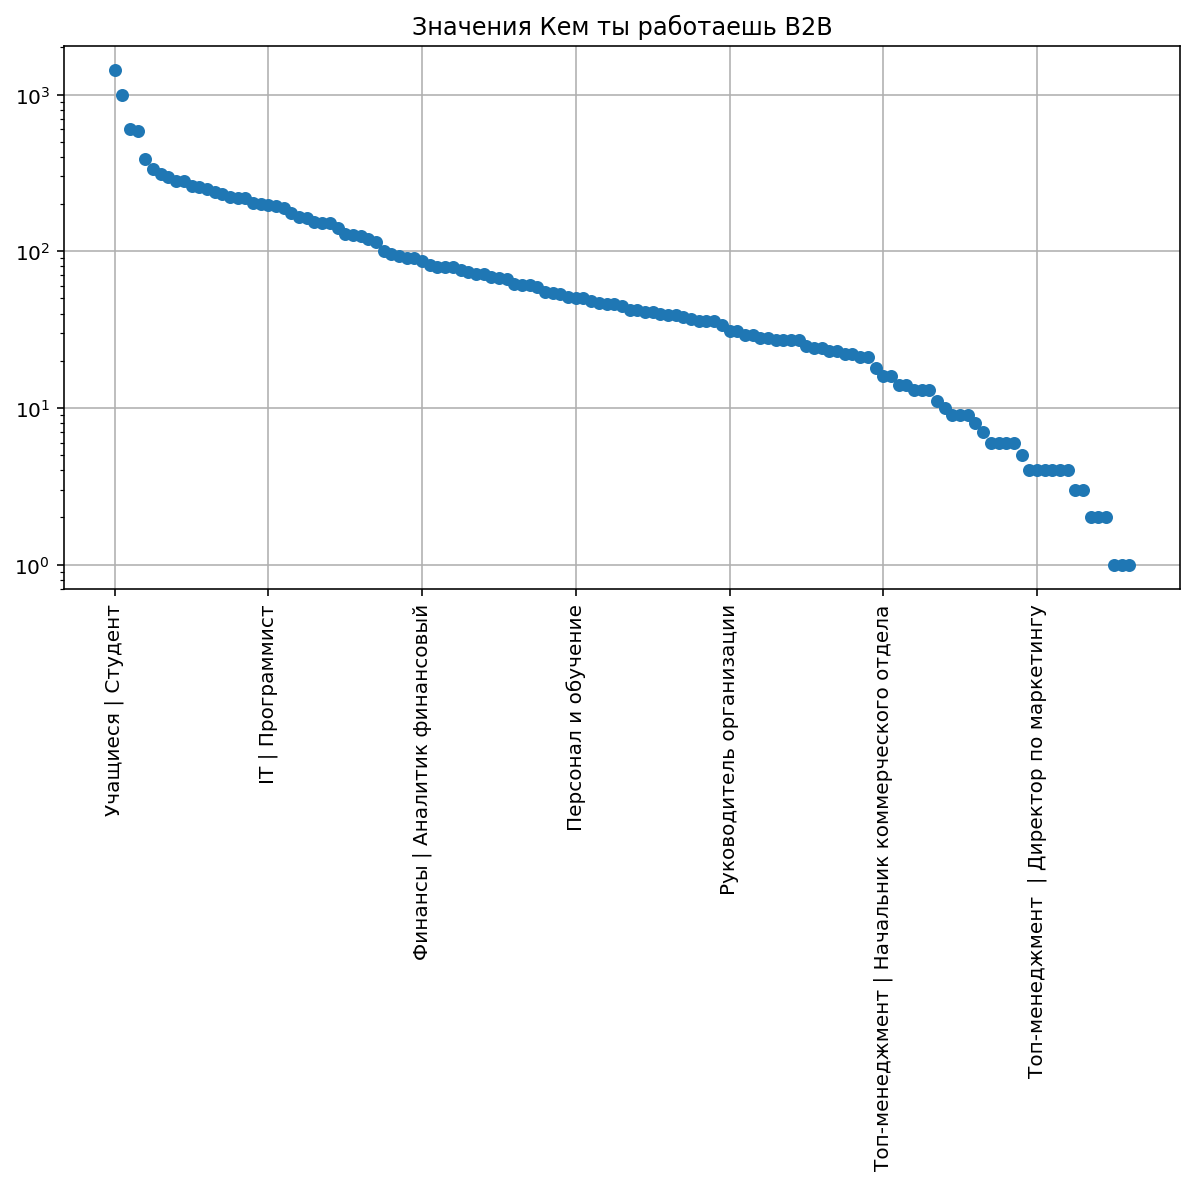

In [23]:
plt.figure(figsize=(10,5))
b2b_answers.q61.value_counts().plot(
    # Отобразим на графике в логарифмической шкале
    logy = True, title = 'Значения Кем ты работаешь B2B', lw = 0, marker='.', rot = 90,
    markersize = 11, grid = True)
plt.show()

Ответы в этом сегменте выглядят как значения закрытого справочника. Распеределение значений не является равномерным, однако имеет достаточное количество разных значений.

#### B2C

In [24]:
b2c_answers.q61.str.lower().value_counts().head(15)

никем         18222
студент        4798
учусь          3941
школьник       3624
ученик         3412
никем          3267
не работаю     1668
менеджер       1561
бухгалтер      1425
ни кем         1383
юрист          1362
учитель        1293
продавец       1271
школьником     1254
учусь          1223
Name: q61, dtype: int64

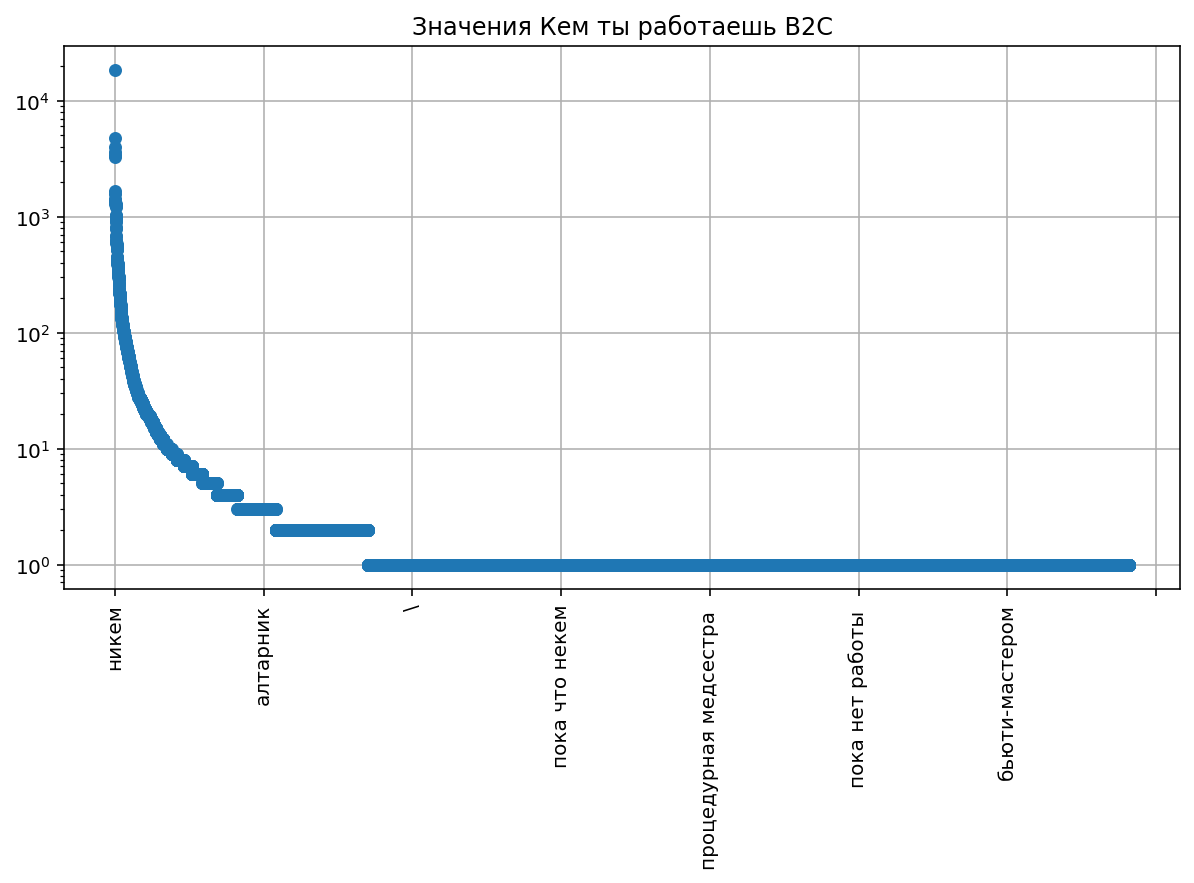

In [25]:
plt.figure(figsize=(10,5))
b2c_answers.q61.str.lower().value_counts().plot(
    # Отобразим на графике в логарифмической шкале
    logy = True, title = 'Значения Кем ты работаешь B2C', lw = 0, marker='.', rot = 90,
    markersize = 11, grid = True)
plt.show()

Видим значения, характерные для открытого вопроса. Большинство записей не относятся к профессиям (никем, учусь, не работаю). Видим длинный хвост редких значений.

#### Сохранение промежуточных данных

Сохраним ответы b2b и b2c.

In [26]:
b2b_answers.to_csv('../datasets/intermediate/b2b_answers.csv')
b2c_answers.to_csv('../datasets/intermediate/b2c_answers.csv')

### Выводы

Мы загрузили два классификтора профессий из сервиса hh.ru. 

Также мы видим, что ответы B2B-сегмента похожи на выбор из закрытого справочника профессий. 

В B2C ответы в свободной форме. Большинство ответов не релевантны профессии. 

Изучим представление этих 4 множеств в векторном пространстве.

## План исследования

1. Возьмем две предобученные модели FastText:
    - статическую модель [araneum_none_fasttextcbow_300_5_2018](https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz) на [RusVectors](https://rusvectores.org/ru/models/)
    - модель Facebook [FastText Russian](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz) на [Word vectors for 157 languages](https://fasttext.cc/docs/en/crawl-vectors.html)
2. Получим вектрное представление для 4 множеств докуменов, описывающих профессии: профессиональные роли hh.ru, профессиональные специализации hh.ru, професии из ответов b2b-сервиса и ответы на вопрос "Кем ты работаешь" b2c-сервиса.
3. Сделаем визуальный анализ профессий в векторном пространстве для оценки степени разделения похожих и не похожих профессий.
4. Определим целевой классификатор (роли или специализации) на основании анализа.
5. Рассчитаем целевые эмбеддинги (предложения ли сумма эмебдингов слов) для выбранного классификатора, будем называть их LABELS.
6. Для каждого ответа b2c сегмента сегмента определяем его эмбеддинг и рассчитываем расстояние (например [cosine_similarity](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) до каждой LABELS, выбираем label с минимальным расстоянием как подходящую профессию.
7. Изучим распределение расстояний и оценим состоятельность алгоритма сопоставления ответов на вопрос "Кем ты работаешь" и справочника профессий. 

## Преобразование в векторное пространство

### Загрузка моделей

Загрузим предобученные модели в формате [KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [27]:
araneum_path = '../models/araneum/araneum_none_fasttextcbow_300_5_2018.model'
cc_ru_path = '../models/cc_ru_300_kv/cc_ru_300.kv'

In [28]:
a_model = fasttext.FastTextKeyedVectors.load(araneum_path)

In [29]:
c_model = fasttext.FastTextKeyedVectors.load(cc_ru_path)

### Преобразование

Преобразуем названия профессий в документы -- списки слов.

In [30]:
prof_roles_docs = tokenize_texts(prof_roles.apply(concat_prof, axis = 1).to_list())
prof_specializations_docs = tokenize_texts(prof_specializations.apply(concat_prof, axis = 1).to_list())

Преобразуем в документы уникальные значения.

In [31]:
b2b_docs = tokenize_texts(b2b_answers.q61.unique())
b2c_docs = tokenize_texts(b2c_answers.q61.unique())

#### Модель Araneum

Преобразуем документы в вектора для разных моделей.

In [32]:
v_prof_roles_a = docs_2_vec(model = a_model, 
                            documents = prof_roles_docs)

In [33]:
v_prof_specializations_a = docs_2_vec(model = a_model, 
                                      documents = prof_specializations_docs)

In [34]:
v_b2b_a = docs_2_vec(model=a_model,
                     documents=b2b_docs)

In [35]:
v_b2c_a = docs_2_vec(model=a_model, documents=b2c_docs)

#### Модель cc_ru

In [36]:
v_prof_roles_c = docs_2_vec(model = c_model, 
                            documents = prof_roles_docs)

In [37]:
v_prof_specializations_c = docs_2_vec(model = c_model, 
                                      documents = prof_specializations_docs)

In [38]:
v_b2b_c = docs_2_vec(model=c_model,
                     documents=b2b_docs)

In [39]:
v_b2c_c = docs_2_vec(model=c_model, documents=b2c_docs)

## Визуализация

### Модель Araneum PCA Plot

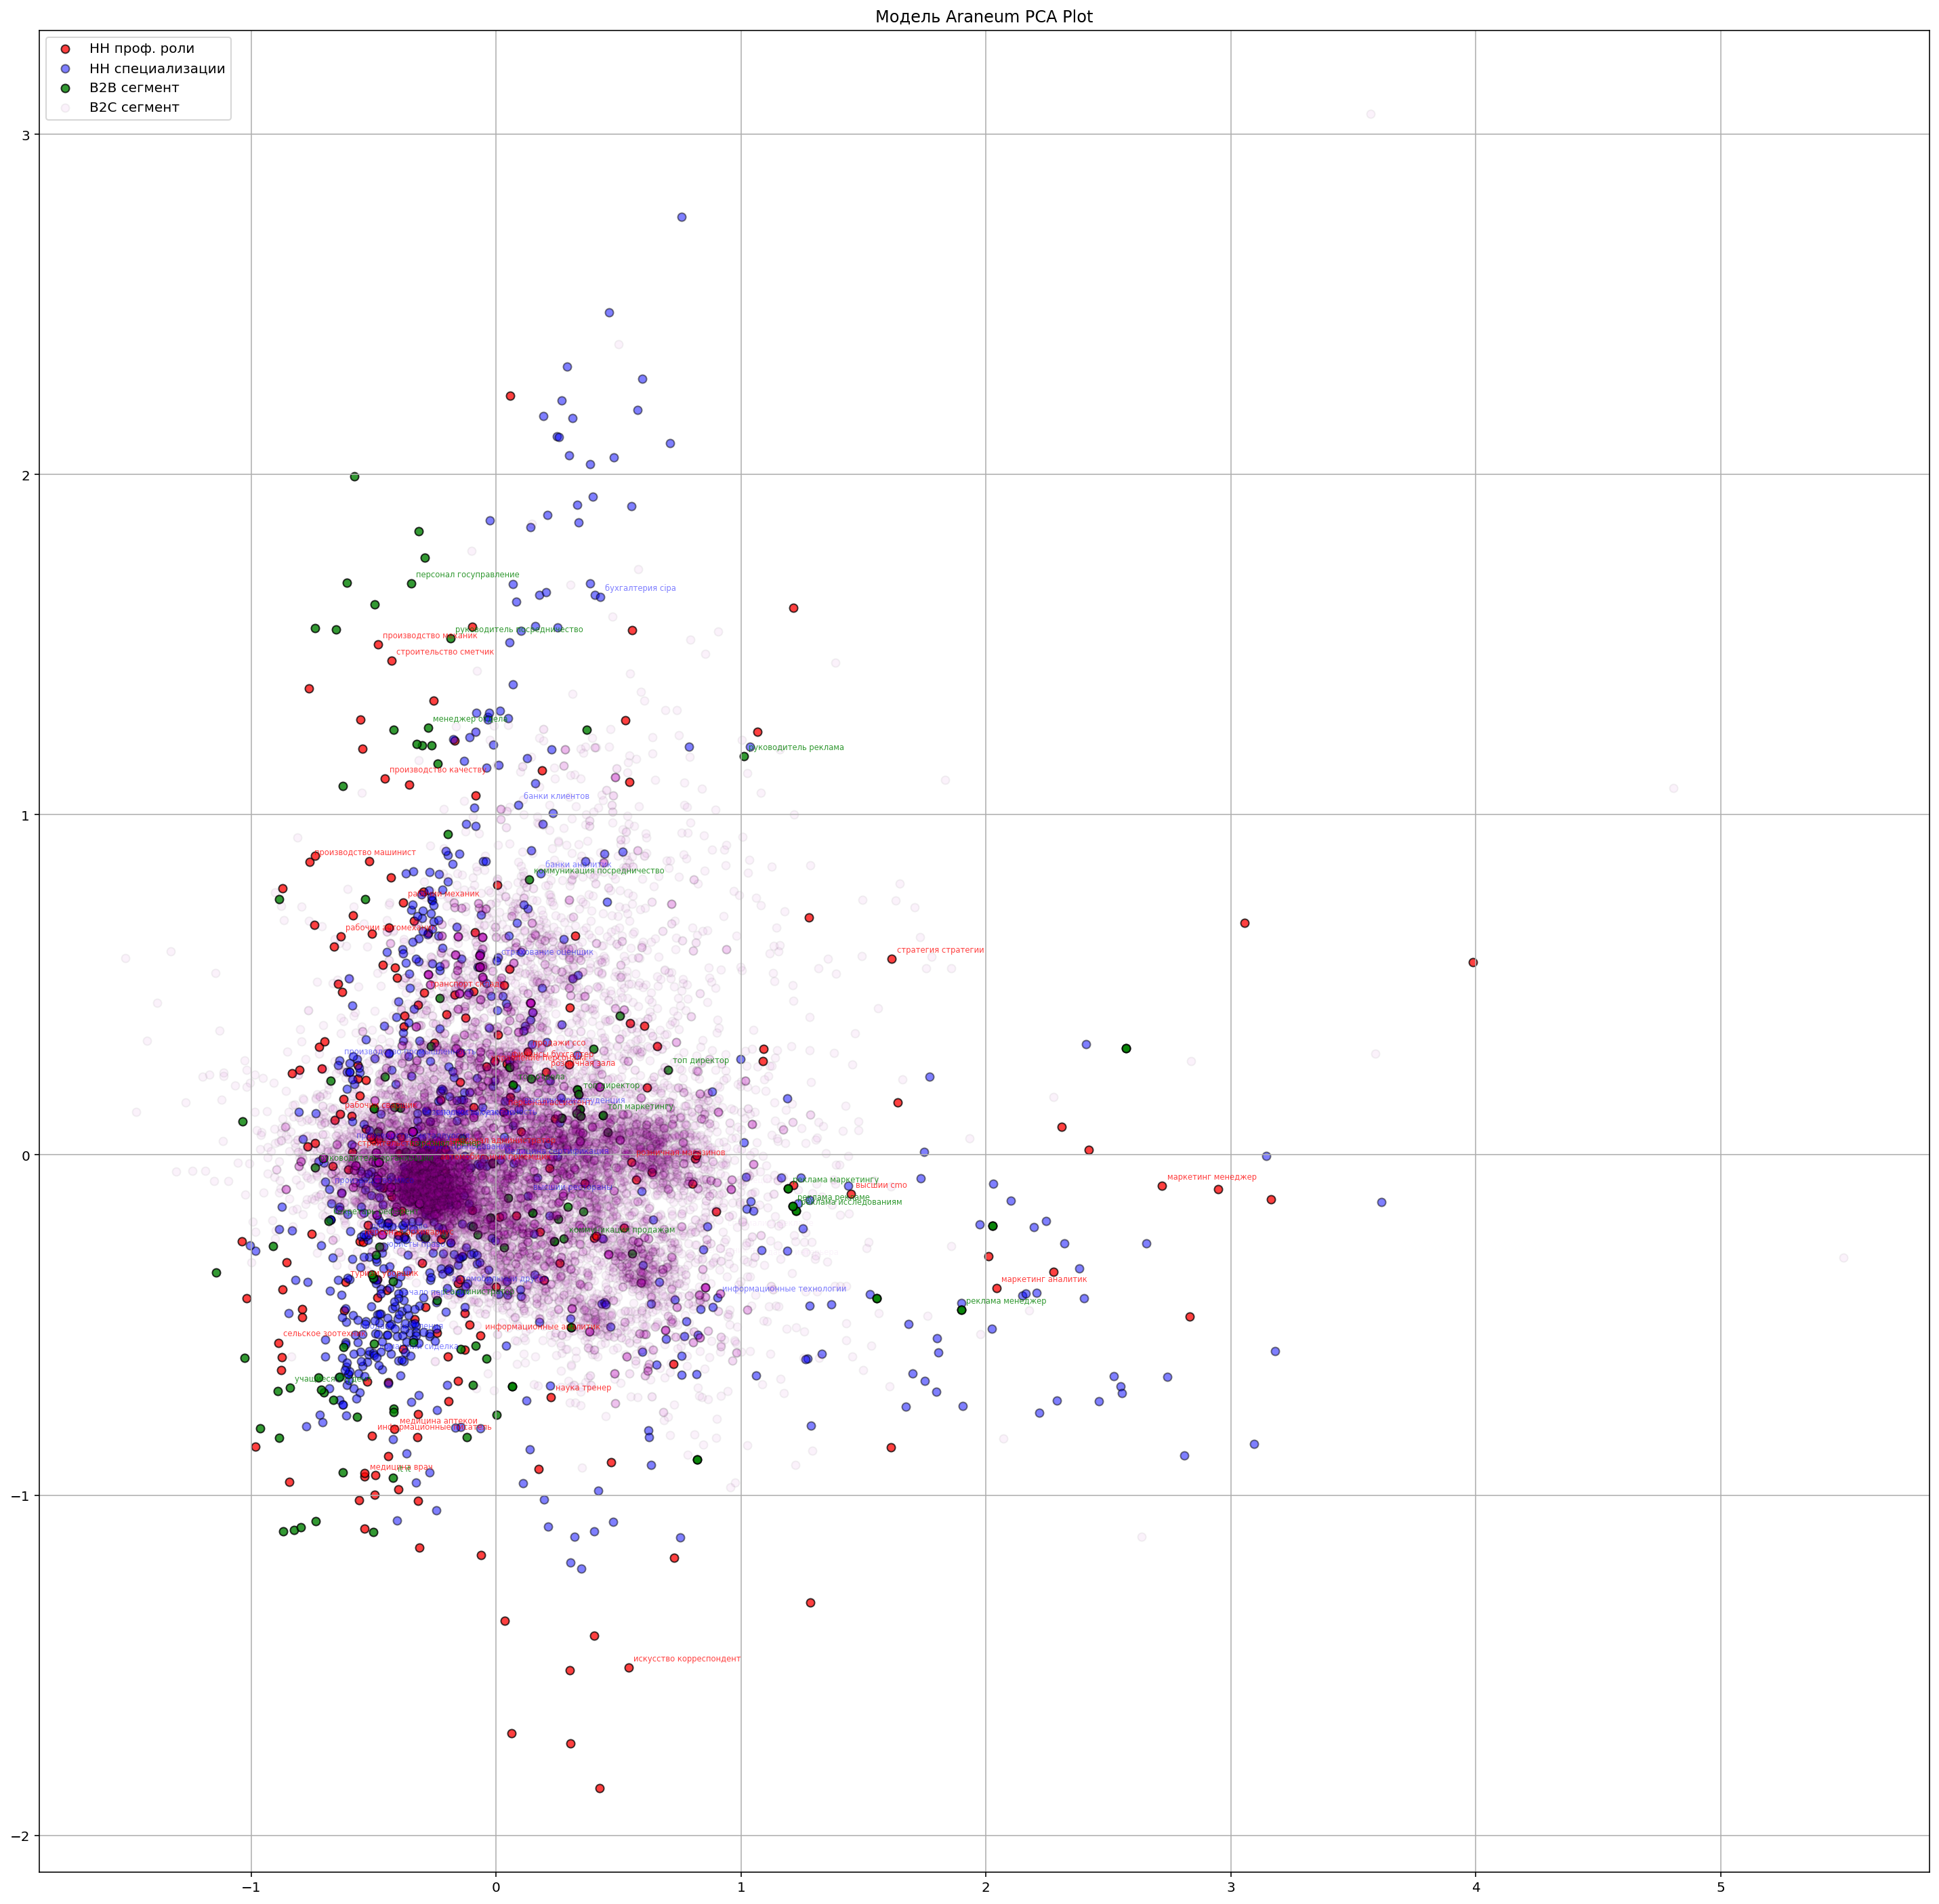

In [40]:
plt.figure(figsize=(25, 25))

# prof_roles
display_pca_scatterplot(vectors=v_prof_roles_a, 
                        documents=prof_roles_docs,
                        label='HH проф. роли',
                        color='r', alpha=.75, n_labels=30)

# prof_specialities
display_pca_scatterplot(vectors=v_prof_specializations_a, 
                        documents=prof_specializations_docs,
                        label='HH специализации',
                        color='b', alpha=.5, n_labels=20)

# b2b
display_pca_scatterplot(vectors=v_b2b_a, 
                        documents=b2b_docs,
                        label='B2B сегмент',
                        color='g', alpha=.8, n_labels=20)

# b2с
display_pca_scatterplot(vectors=v_b2c_a, 
                        documents=b2c_docs,
                        label='B2C сегмент',
                        color='m', alpha=.05, n_labels=20)


plt.grid(visible = True)
plt.legend(loc='upper left')
plt.title('Модель Araneum PCA Plot')
plt.show()

### Модель cc_ru PCA Plot

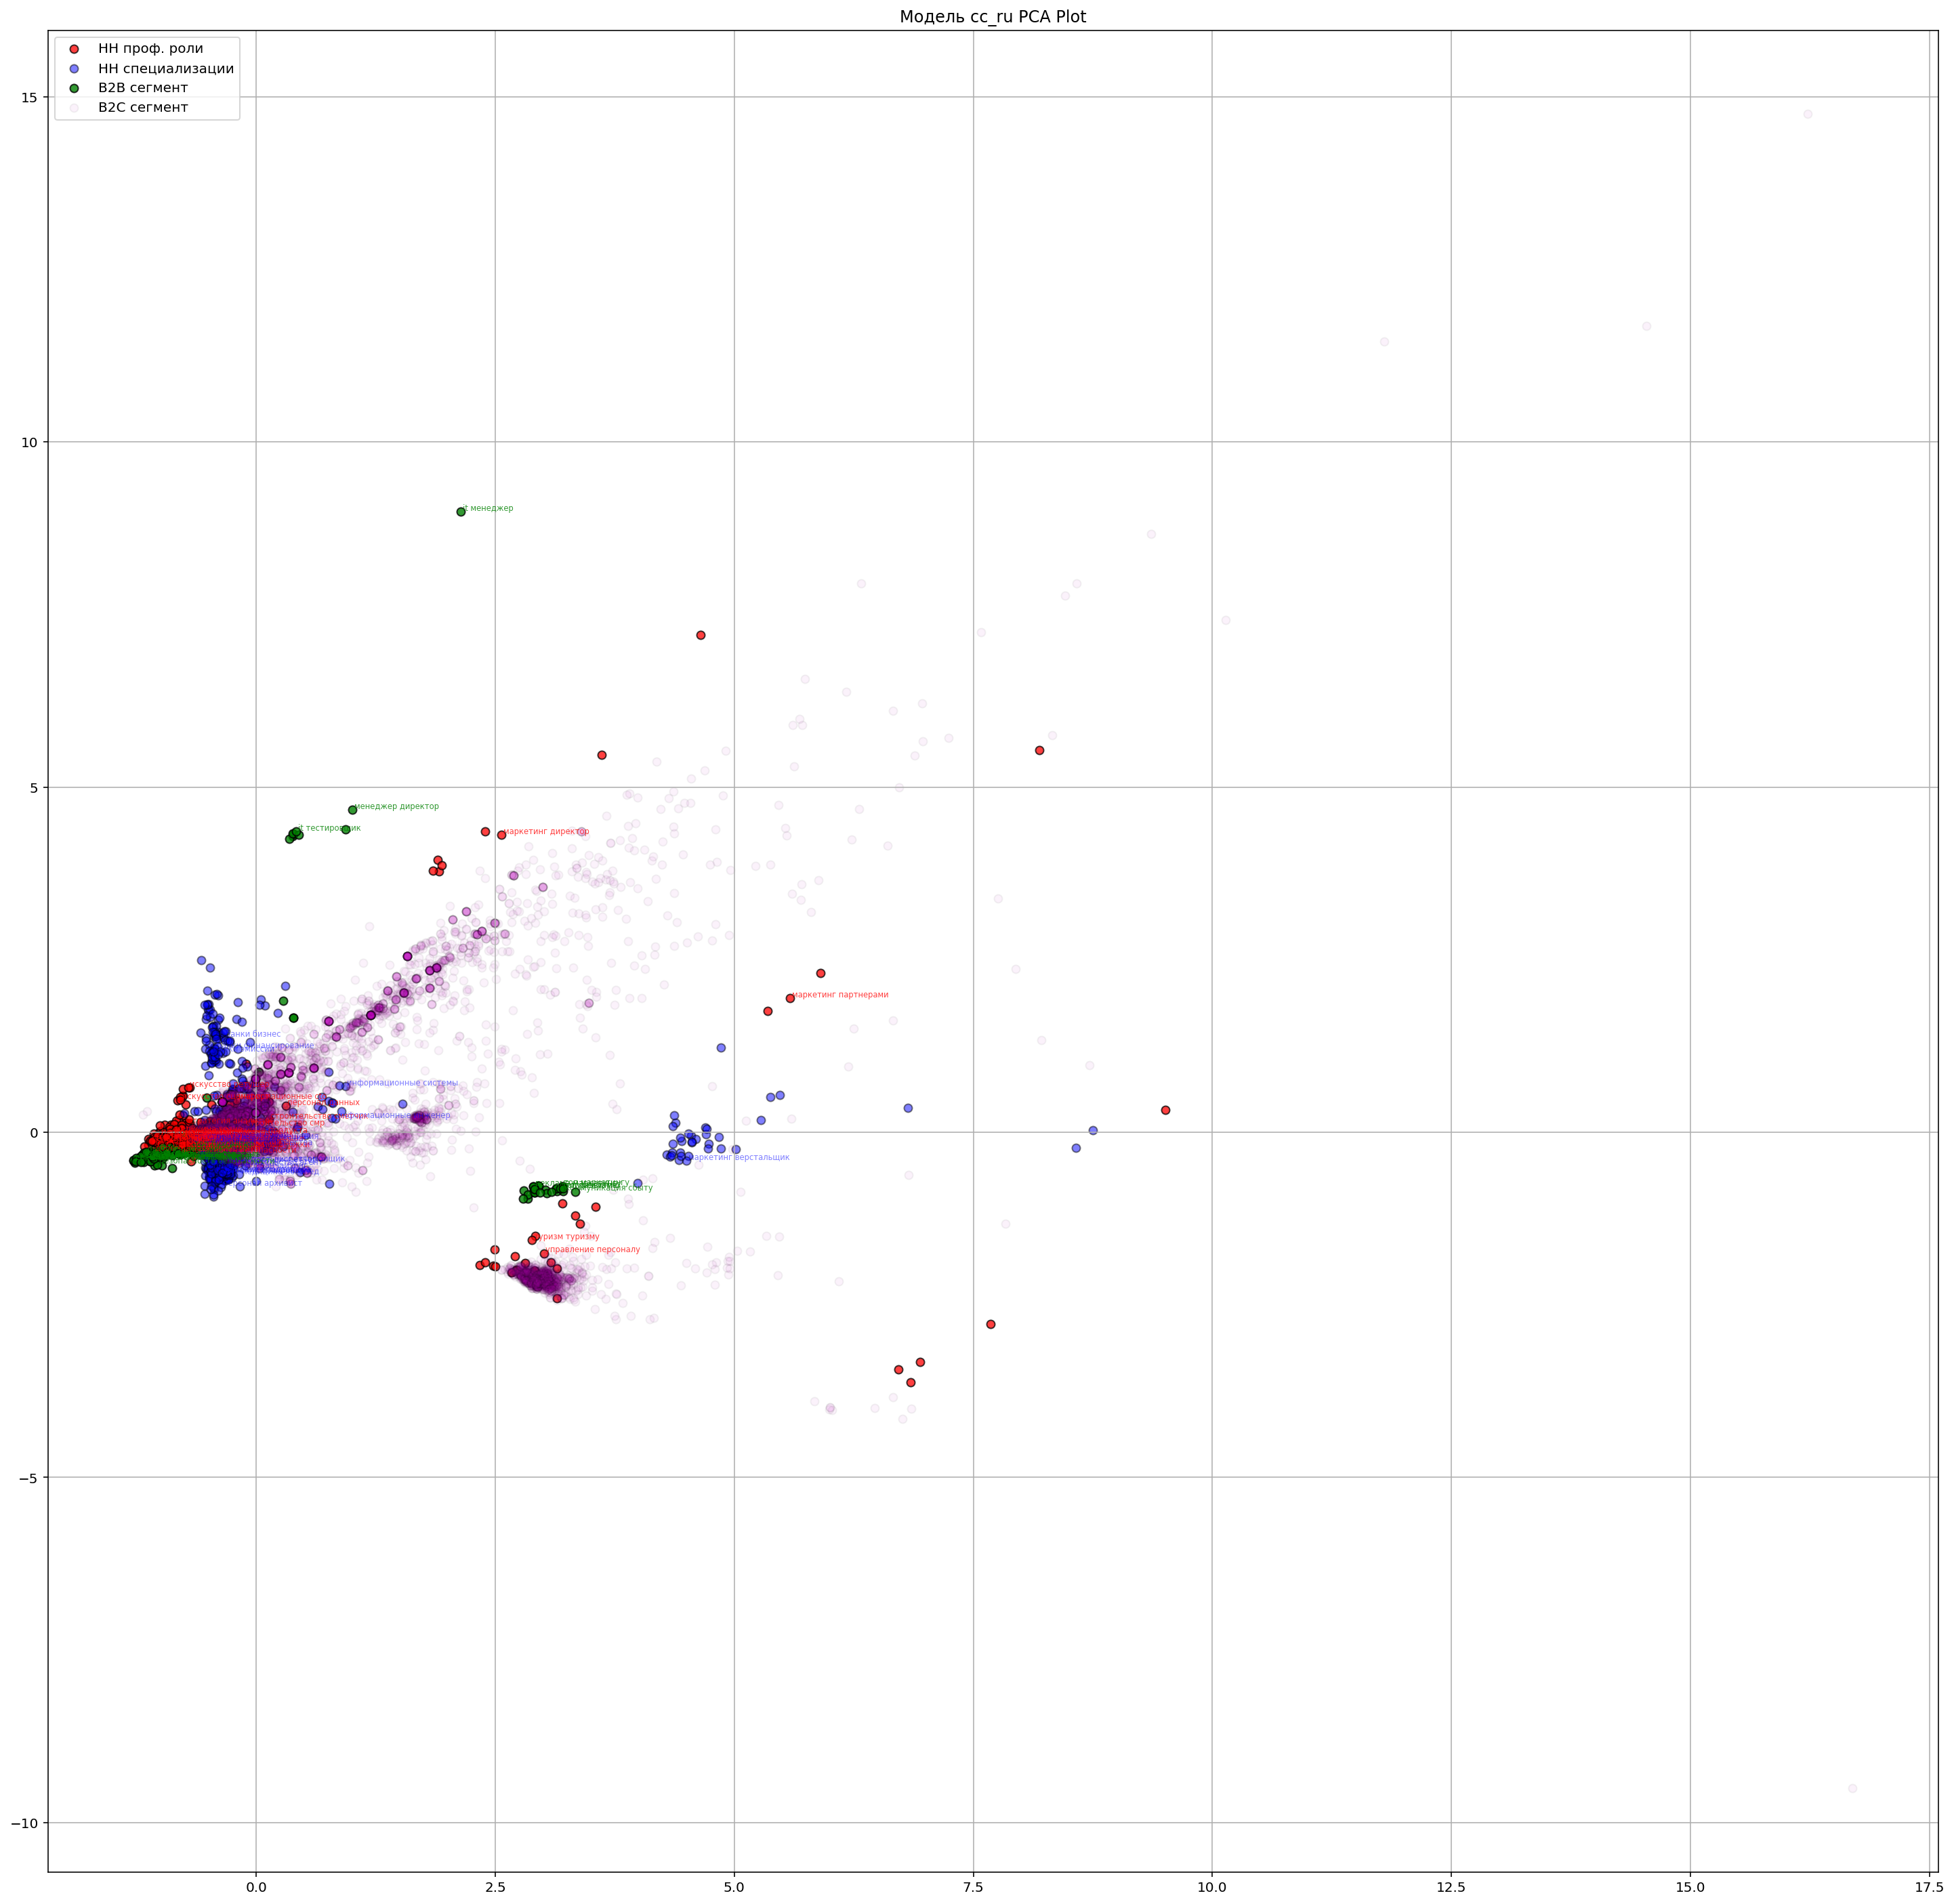

In [41]:
plt.figure(figsize=(25, 25))

# prof_roles
display_pca_scatterplot(vectors=v_prof_roles_c, 
                        documents=prof_roles_docs,
                        label='HH проф. роли',
                        color='r', alpha=.75, n_labels=30)

# prof_specialities
display_pca_scatterplot(vectors=v_prof_specializations_c, 
                        documents=prof_specializations_docs,
                        label='HH специализации',
                        color='b', alpha=.5, n_labels=20)

# b2b
display_pca_scatterplot(vectors=v_b2b_c, 
                        documents=b2b_docs,
                        label='B2B сегмент',
                        color='g', alpha=.8, n_labels=20)

# b2с
display_pca_scatterplot(vectors=v_b2c_c, 
                        documents=b2c_docs,
                        label='B2C сегмент',
                        color='m', alpha=.05, n_labels=20)


plt.grid(visible = True)
plt.legend(loc='upper left')
plt.title('Модель cc_ru PCA Plot')
plt.show()

## Сохранение векторов

Сохраним вектора в формате, пригодном для анализа в TensorFlow [Embedding Projector](https://projector.tensorflow.org).

### Вектора модели Araneum

In [42]:
all_vectors_a = np.concatenate((v_prof_roles_a, v_prof_specializations_a, v_b2b_a, v_b2c_a), axis=0)
all_vectors_a.shape          

(20840, 300)

In [43]:
np.savetxt('../datasets/processed/araneum_vectors.tsv', all_vectors_a)

### Вектора модели cc_ru

In [44]:
all_vectors_c = np.concatenate((v_prof_roles_c, v_prof_specializations_c, v_b2b_c, v_b2c_c), axis=0)
all_vectors_c.shape          

(20840, 300)

In [45]:
np.savetxt('../datasets/processed/cc_ru_vectors.tsv', all_vectors_a)

### Метаданные

In [46]:
labels_prof_roles = [[' '.join(words), 'hh prof roles'] for words in prof_roles_docs]
labels_prof_specialization = [
    [' '.join(words), 'hh prof specialization'] for words in prof_specializations_docs]
labels_b2b = [[' '.join(words), 'b2b segment'] for words in b2b_docs]
labels_b2c = [[' '.join(words), 'b2c segment'] for words in b2c_docs]

In [47]:
all_labels = np.concatenate((labels_prof_roles, 
                             labels_prof_specialization, 
                             labels_b2b, 
                             labels_b2c), axis=0)
all_labels = pd.DataFrame(all_labels, columns=['label', 'type'])

In [48]:
all_labels.shape

(20840, 2)

In [49]:
all_labels.to_csv('../datasets/processed/profession_lables.tsv', sep='\t', index=False)

## Анализ расстояний

## Выводы